In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import dlib
import os
from keras import models, layers
from keras.utils import np_utils
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
import pickle

C:\Users\ian\Anaconda3\envs\forge\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)
Using TensorFlow backend.


In [3]:
#Returns the default rectangle face detector
hog_detector = dlib.get_frontal_face_detector()
#This object detects human faces in an image. The constructor loads the face detection model from mmod_human_face_detector.dat
cnn_detector = dlib.cnn_face_detection_model_v1('models/mmod_human_face_detector.dat')

def locate_faces(image, model="hog"):
    
    if model == "hog":
        detector = hog_detector
        cst = 0
    elif model == "cnn":
        detector = cnn_detector
        cst = 10
            
    matches = detector(image,1)
    rects   = []
    
    for r in matches:
        if model == "cnn":
            r = r.rect
        x = max(r.left(), 0)
        y = max(r.top(), 0)
        w = min(r.right(), image.shape[1]) - x + cst
        h = min(r.bottom(), image.shape[0]) - y + cst
        rects.append((x,y,w,h))
        
    return rects

In [4]:
def extract_faces(image, model="hog"):
    
    gray  = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    rects = locate_faces(gray, model)
    faces = []
    
    for (x,y,w,h) in rects:
        cropped = image[y:y+h, x:x+w, :]
        cropped = cv2.resize(cropped, (128,128))
        faces.append(cropped)
        
    return faces

In [6]:
def read_images(basePath):
    
    imagePaths = []
    labels = []
    Labels = []
    i = -1
    
    # loop over the directory structure
    for (rootDir, dirNames, fileNames) in os.walk(basePath):
        
        if np.size(labels) == 0:
            labels = dirNames
        i = i+1
        
        # loop over the filenames in the current directory
        for filename in fileNames:
            
            # determine the file extension of the current file
            ext = filename[filename.rfind("."):].lower()
            # check to see if the file is an image and should be processed
            if ext.endswith((".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")):
                # construct the path to the image and yield it
                imagePath = os.path.join(rootDir, filename).replace(" ", "\\ ")
                imagePaths.append(imagePath)
                Labels.append(i)
    
    return imagePaths,Labels,labels

In [7]:
imagePaths, Labels, labels = read_images("samples")
Faces = []
for i in range(np.size(Labels)):
    image = cv2.imread(imagePaths[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    face = extract_faces(image, "hog")
    print(i+1,'/',np.size(Labels))
    if np.shape(face)[0] != 1:
        Labels[i] = 'null'
        imagePaths[i] = 'null'
        continue
    Faces.append(face[0])

1 / 232
2 / 232
3 / 232
4 / 232
5 / 232
6 / 232
7 / 232
8 / 232
9 / 232
10 / 232
11 / 232
12 / 232
13 / 232
14 / 232
15 / 232
16 / 232
17 / 232
18 / 232
19 / 232
20 / 232
21 / 232
22 / 232
23 / 232
24 / 232
25 / 232
26 / 232
27 / 232
28 / 232
29 / 232
30 / 232
31 / 232
32 / 232
33 / 232
34 / 232
35 / 232
36 / 232
37 / 232
38 / 232
39 / 232
40 / 232
41 / 232
42 / 232
43 / 232
44 / 232
45 / 232
46 / 232
47 / 232
48 / 232
49 / 232
50 / 232
51 / 232
52 / 232
53 / 232
54 / 232
55 / 232
56 / 232
57 / 232
58 / 232
59 / 232
60 / 232
61 / 232
62 / 232
63 / 232
64 / 232
65 / 232
66 / 232
67 / 232
68 / 232
69 / 232
70 / 232
71 / 232
72 / 232
73 / 232
74 / 232
75 / 232
76 / 232
77 / 232
78 / 232
79 / 232
80 / 232
81 / 232
82 / 232
83 / 232
84 / 232
85 / 232
86 / 232
87 / 232
88 / 232
89 / 232
90 / 232
91 / 232
92 / 232
93 / 232
94 / 232
95 / 232
96 / 232
97 / 232
98 / 232
99 / 232
100 / 232
101 / 232
102 / 232
103 / 232
104 / 232
105 / 232
106 / 232
107 / 232
108 / 232
109 / 232
110 / 232
111 / 23

In [12]:
print(labels)
Labels = np.array(Labels)
while 'null' in Labels:
    Labels.remove('null')
while 'null' in imagePaths:
    imagePaths.remove('null')
print(Labels.shape)

['alan_grant', 'ellie_sattler', 'ian_malcolm', 'john_hammond', 'zhang_yiheng']
(174,)


C:\Users\ian\Anaconda3\envs\forge\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  This is separate from the ipykernel package so we can avoid doing imports until


Label: 1 alan_grant
Path: samples\alan_grant\00000017.jpg


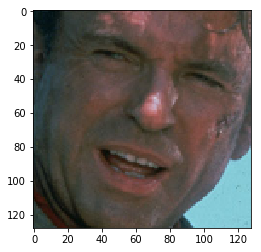

In [13]:
i = 2
plt.imshow(Faces[i])
print('Label:',Labels[i],labels[Labels[i]-1])
print('Path:',imagePaths[i])

In [16]:
#Take an image of a human face as input and identify the locations of important facial landmarks
pose68 = dlib.shape_predictor('models/shape_predictor_68_face_landmarks.dat')
pose05 = dlib.shape_predictor('models/shape_predictor_5_face_landmarks.dat')

def face_landmarks(face, model="large"):
    
    if model == "large":
        predictor = pose68
    elif model == "small":
        predictor = pose05
    
    if not isinstance(face, list):
        rect = dlib.rectangle(0,0,face.shape[1],face.shape[0])
        return predictor(face, rect)
    else:
        rect = dlib.rectangle(0,0,face[0].shape[1],face[0].shape[0])
        return [predictor(f,rect) for f in face]

In [17]:
#encode a face into 128 vectors
cnn_encoder = dlib.face_recognition_model_v1('models/dlib_face_recognition_resnet_model_v1.dat')

def face_encoder(faces):
    
    landmarks = face_landmarks(faces)
    
    if not isinstance(faces, list):
        return np.array(cnn_encoder.compute_face_descriptor(faces,landmarks))
    else:
        return np.array([cnn_encoder.compute_face_descriptor(f,l) for f,l in zip(faces,landmarks)])

In [18]:
encoded_faces = face_encoder(Faces)
encoded_faces = np.array(encoded_faces)
encoded_faces.shape

(174, 128)

In [19]:
Labels = np_utils.to_categorical(Labels-1, num_classes=5)
x_train,x_test, y_train, y_test = train_test_split(encoded_faces,Labels,test_size=0.3, random_state=0)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(121, 128)
(121, 5)
(53, 128)
(53, 5)


In [30]:
model = models.Sequential()
model.add(layers.Dense(33, activation='relu', input_shape=(128,)))
model.add(layers.Dense(5, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model_hist = model.fit(x_train, y_train, epochs=25, batch_size=10)
model.evaluate(x_test, y_test, batch_size=1)

Epoch 1/25
121/121 [==============================] - 0s 3ms/step - loss: 1.5700 - acc: 0.3636
Epoch 2/25
121/121 [==============================] - 0s 400us/step - loss: 1.4605 - acc: 0.3884
Epoch 3/25
121/121 [==============================] - 0s 454us/step - loss: 1.3778 - acc: 0.5455
Epoch 4/25
121/121 [==============================] - 0s 429us/step - loss: 1.3018 - acc: 0.5455
Epoch 5/25
121/121 [==============================] - 0s 429us/step - loss: 1.2222 - acc: 0.5868
Epoch 6/25
121/121 [==============================] - 0s 420us/step - loss: 1.1457 - acc: 0.7190
Epoch 7/25
121/121 [==============================] - 0s 404us/step - loss: 1.0736 - acc: 0.8678
Epoch 8/25
121/121 [==============================] - 0s 495us/step - loss: 0.9987 - acc: 0.8926
Epoch 9/25
121/121 [==============================] - 0s 429us/step - loss: 0.9239 - acc: 0.9091
Epoch 10/25
121/121 [==============================] - 0s 420us/step - loss: 0.8533 - acc: 0.9008
Epoch 11/25
121/121 [==========

[0.26775329011791155, 0.9811320754716981]

In [21]:
def label_faces(encoded_faces):
    encoded = np.array(encoded_faces).reshape(1,128)
    label = model.predict_classes(encoded, batch_size=1)
    acc = model.predict(encoded, batch_size=1)
    tag = str(labels[label[0]]) + ' '+ str(int(acc[0,label[0]]*100))+'%'
    return tag

In [22]:
def process_frame(image, mode="fast"):
    
    # face detection to get rectangles 
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if mode == "fast":
        matches = hog_detector(gray,1)
    else:
        matches = cnn_detector(gray,1)
        matches = [m.rect for m in matches]
        
    # for each face in a frame
    for rect in matches:
        
        # face landmarks to get 68 feature dots
        landmarks = pose68(gray, rect)
        
        # face encoding
        encoding = cnn_encoder.compute_face_descriptor(image, landmarks)
        
        # face classification use neural network
        label = label_faces(encoding)
        
        # draw box
        cv2.rectangle(image, (rect.left(), rect.top()), (rect.right(), rect.bottom()), (0, 255, 0), 2)
        y = rect.top() - 15 if rect.top() - 15 > 15 else rect.bottom() + 25
        cv2.putText(image, label, (rect.left(), y), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 0), 2)
        
    return image

In [23]:
def process_movie(video_name, mode="fast"):
    
    video  = cv2.VideoCapture(video_name)
    i = 0
    try:
        
        while True:

            # Grab a single frame of video
            ret, frame = video.read()
            
            # Resize frame of video for faster processing
            frame = cv2.resize(frame, (0, 0), fx=0.5, fy=0.5)

            # Quit when the input video file ends or key "Q" is pressed
            key = cv2.waitKey(1) & 0xFF
            if not ret or key == ord("q"):
                break

            # Process frame
            if i%5 == 0:
                image = process_frame(frame, mode)

            # Display the resulting image
            cv2.imshow('Video', image)
            i = i + 1
    
    finally:
        video.release()
        cv2.destroyAllWindows()
        print("Video released")

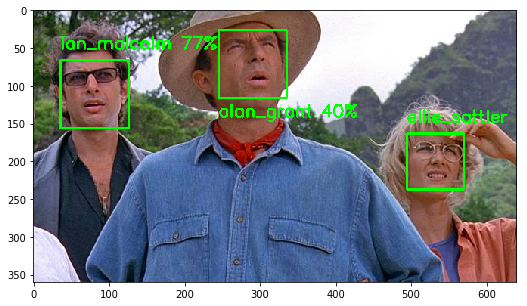

In [31]:
image = cv2.imread("test/example_03.png")
processed = process_frame(image.copy())
processed = cv2.cvtColor(processed, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15,5))
plt.imshow(processed)

In [32]:
process_movie("test/lunch_scene.mp4")

Video released


In [33]:
process_movie(0)

Video released
